### Классификация активностей человека

Рассмотрим задачу классификации набора данных, содержащего временные ряды, с помощью CWT + CNN.

Набор данных UCI-HAR (Human Activity Recognition) содержит измерения датчиков людей, выполняющих различные виды физической активности, например, подъем или спуск по лестнице, лежание, стояние, ходьбу и т. д. Данные в наборе получены от тридцати добровольцев с закрепленным на поясе Samsung Galaxy S II. В датасете более 10 000 сигналов, каждый из которых состоит из девяти компонентов (ускорение x, ускорение y, ускорение z, данные гироскопа x,y,z и т. д.). 

Датасет доступен по ссылке:

https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

Сначала сформируем датасет для обучения. Для этого подгрузим сигналы и сделаем их НВП.

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm

In [3]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = './HAR_Dataset/train/InertialSignals/'
INPUT_FOLDER_TEST = './HAR_Dataset/test/InertialSignals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = './HAR_Dataset/train/y_train.txt'
LABELFILE_TEST = './HAR_Dataset/test/y_test.txt'

train_signals, test_signals = [], []

In [5]:
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("Обучающая выборка состоит из {} сигналов, каждый сигнал длины {} и из {} компонент ".format(no_signals_train, no_steps_train, no_components_train))
print("Тестовая выборка состоит из {} сигналов, каждый сигнал длины {} и из {} компонент ".format(no_signals_test, no_steps_test, no_components_test))
print("Обучающая выборка состоит из {} меток классов с распределением:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("Тестовая выборка состоит из {} меток классовс распределением:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

Обучающая выборка состоит из 7352 сигналов, каждый сигнал длины 128 и из 9 компонент 
Тестовая выборка состоит из 2947 сигналов, каждый сигнал длины 128 и из 9 компонент 
Обучающая выборка состоит из 7352 меток классов с распределением:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
Тестовая выборка состоит из 2947 меток классовс распределением:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


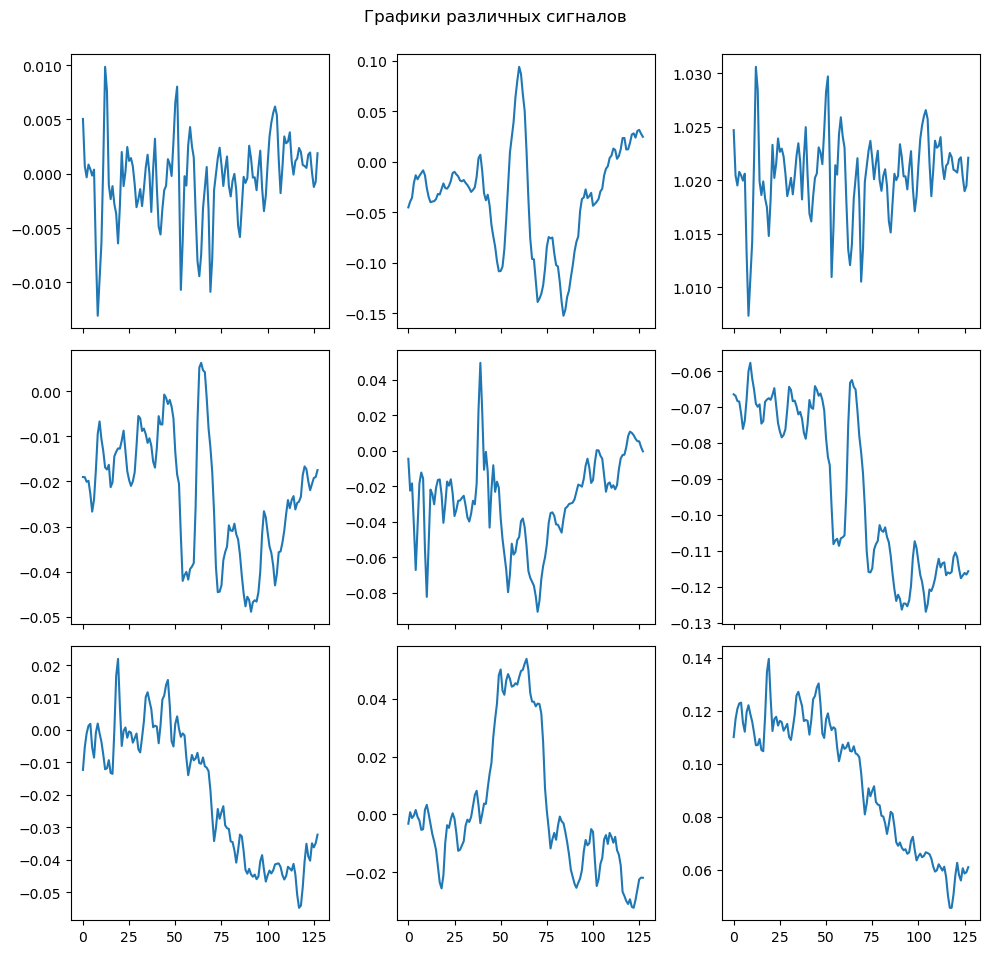

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True)
x = np.arange(0, 128, 1.0)
for i in range(3):
    for j in range(3):
        axs[i, j].plot(x, uci_har_signals_train[0,:,i+3*j])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Графики различных сигналов")
plt.show()

In [15]:
scales = range(1,128,2)
waveletname = 'morl'
len(scales)

64

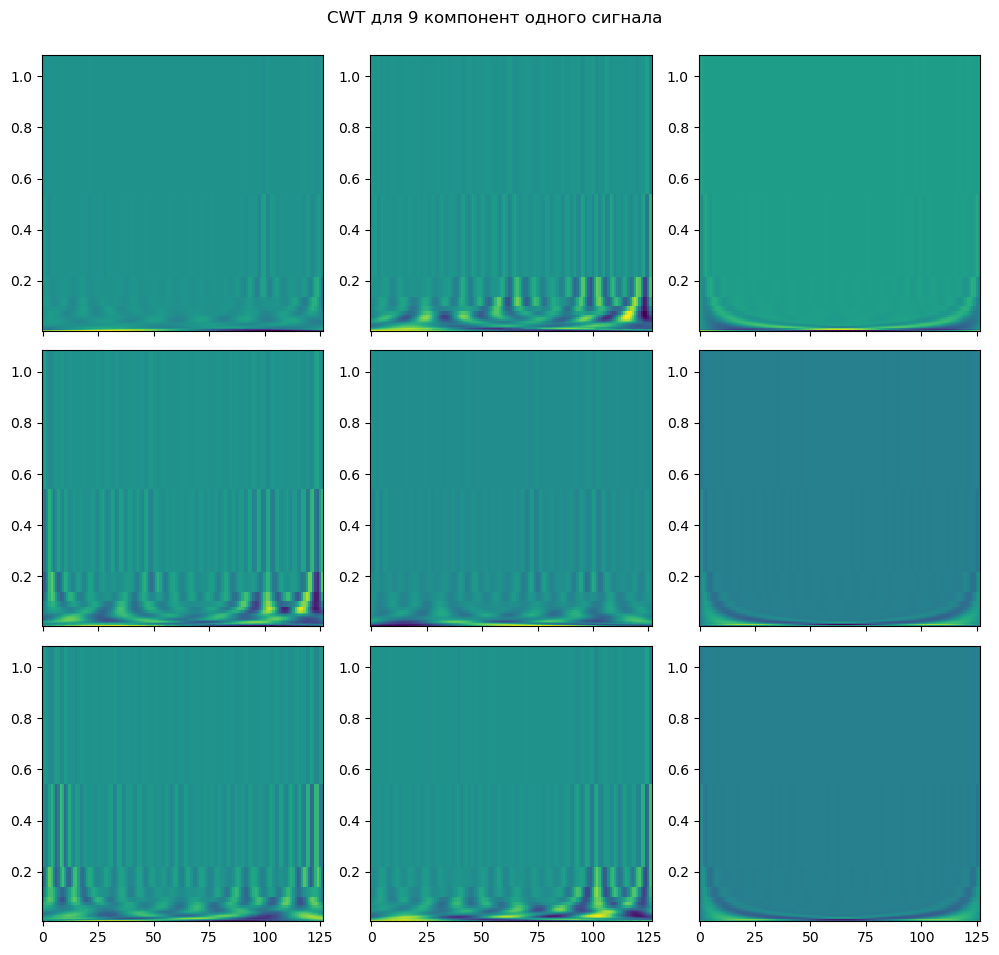

In [29]:
ii = 1000
data_cwt = np.ndarray(shape=(9, len(scales), 127))
freq_cwt = np.ndarray(shape=(9, len(scales)))

for jj in range(0,9):
    signal = uci_har_signals_train[ii, :, jj]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:127]
    data_cwt[jj, :, :, ] = coeff_.astype('float32')
    freq_cwt[jj, :] = freq

fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True)

for i in range(3):
    for j in range(3):
        axs[i,j].pcolormesh(np.arange(127), freq_cwt[i+3*j], data_cwt[i+3*j])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("CWT для 9 компонент одного сигнала")
plt.show()

### Задача. 

Сформировать свёрточную ИНС и обучить на датасете `(train_data_cwt, target_train)`.

Точность на тестовом датасете не меньше 95%.

In [31]:
scales = range(1,128,2)
waveletname = 'morl'
train_size = 7352 
test_size = 2947

# Сформировать датасеты
train_data_cwt = np.ndarray(shape=(train_size, 9, len(scales), 127))
test_data_cwt = np.ndarray(shape=(test_size, 9, len(scales), 127))


Нахождение CWT занимает время (порядка 5 мин). Сформированные массивы с CWT можно сохранить.

In [169]:
with open('data_train.npy', 'wb') as f:
    np.save(f, train_data_cwt)
with open('data_test.npy', 'wb') as f:
    np.save(f, test_data_cwt)

In [194]:
with open('data_train.npy', 'rb') as f:
    train_data_cwt = np.load(f)
with open('data_test.npy', 'rb') as f:
    test_data_cwt = np.load(f)

Сформируем обучающий и тестовый датасеты.

In [33]:
x_train = train_data_cwt
y_train = list(uci_har_labels_train[:train_size])
x_test = test_data_cwt
y_test = list(uci_har_labels_test[:test_size])
num_classes = 6

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (7352, 9, 64, 127)
7352 train samples
2947 test samples


В векторах `y_train` и `y_test` содержатся индексы тех или иных активностей. Переведём их в бинарные вектора методом one-hot encoding.

In [7]:
import torch
import torch.nn as nn

def encode_labels(labels, num_of_classes): 
    num = len(labels)
    target = torch.zeros(num, num_of_classes).float()
    for i, l in enumerate(labels):
        target[i, l] = 1
    return target

target_train = encode_labels(y_train, num_classes)
target_test = encode_labels(y_test, num_classes)

Сформировать свёрточную ИНС и обучить на датасете `(train_data_cwt, target_train)`.

Точность на тестовом датасете `(test_data_cwt, targettarget_test_train)` не меньше 95%.

In [67]:
print(classification_report(y_test, y_pred_labels, target_names=target_names))

                    precision    recall  f1-score   support

           walking       0.95      0.96      0.95       496
  walking upstairs       0.99      0.95      0.97       471
walking downstairs       0.95      0.99      0.97       420
           sitting       0.94      0.87      0.91       491
          standing       0.89      0.95      0.92       532
            laying       0.99      1.00      1.00       537

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947



In [35]:
print(classification_report(y_test, y_pred_labels, target_names=target_names))

                    precision    recall  f1-score   support

           walking       0.89      0.96      0.92       496
  walking upstairs       0.95      0.91      0.93       471
walking downstairs       0.99      0.94      0.96       420
           sitting       0.98      0.90      0.94       491
          standing       0.94      0.96      0.95       532
            laying       0.95      1.00      0.97       537

          accuracy                           0.95      2947
         macro avg       0.95      0.94      0.95      2947
      weighted avg       0.95      0.95      0.95      2947

